# Train finetunned SqueezeNet model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
os.environ['KERAS_BACKEND']='tensorflow'

import tensorflow as tf
tf.__version__

# ## Use tensorflow with CPU
# import tensorflow as tf
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)
# from keras import backend as K
# K.tensorflow_backend.set_session(session=sess)

'1.1.0'

In [4]:
import numpy as np

from data_utils import get_id_type_list_for_class, GENERATED_DATA, OUTPUT_PATH, to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

Using TensorFlow backend.


In [5]:
from models.squeezenet_multiclassification import get_squeezenet, get_squeezenet2

In [6]:
from sklearn.model_selection import KFold, StratifiedKFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import load_pretrained_model, get_label

In [7]:
from xy_providers import image_label_provider

In [ ]:
cnn = get_squeezenet2((256, 256, 3), 17)
cnn.summary()

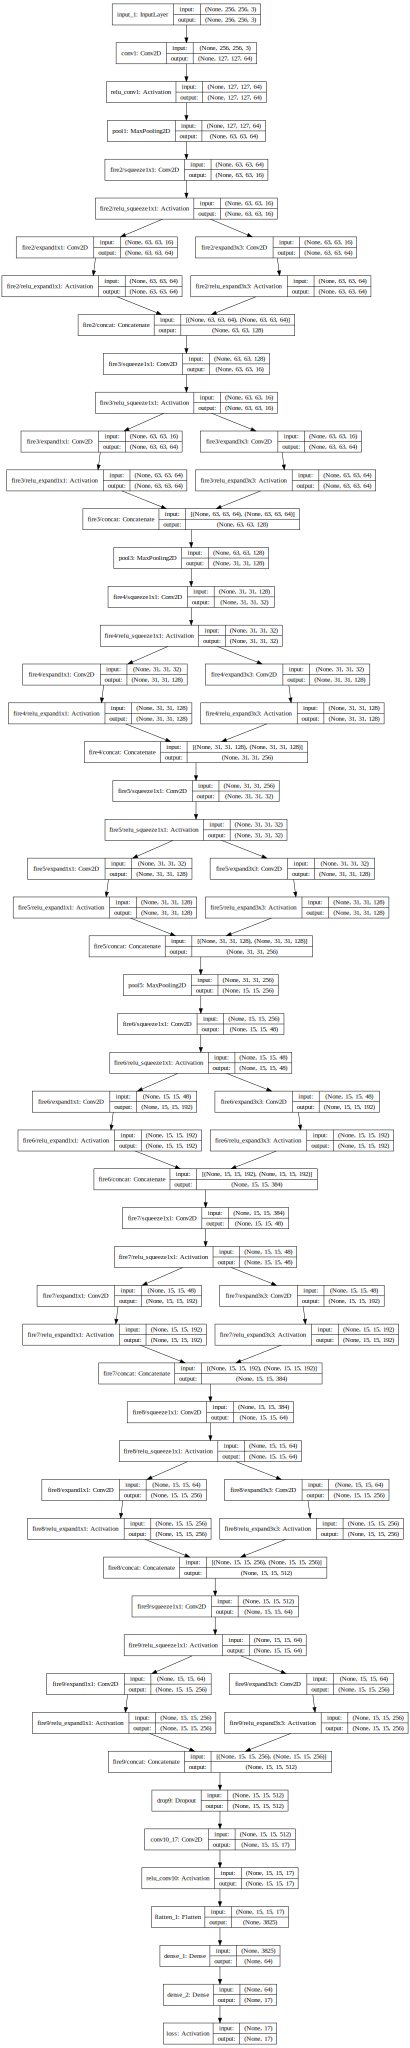

In [8]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

### Setup configuration

In [8]:
seed = 2017
np.random.seed(seed)

In [9]:
trainval_id_type_list = [(image_id, "Train_jpg") for image_id in train_jpg_ids]
np.random.shuffle(trainval_id_type_list)
print(len(trainval_id_type_list))

40479


In [10]:
from data_utils import DataCache

try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(10000)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(10000)

In [11]:
params = {
    'seed': seed,
    
    'xy_provider': image_label_provider,
    
    'network': get_squeezenet2,
    'optimizer': 'adadelta',
    'loss': 'mae',
    'nb_epochs': 50,
    'batch_size': 16,    
    
    'normalize_data': True,
    'normalization': 'vgg',
    
    'image_size': (256, 256),
    
    'lr_kwargs': {
        'lr': 0.01,
        'base': 2,
        'period': 10,
        'init_epoch': 0
    },
    'lr_decay_f': step_decay,
    
    'cache': cache,
    
#     'class_index': 0,
#     'pretrained_model': 'load_best',
#     'pretrained_model': os.path.join(GENERATED_DATA, "weights", ""),
        
    'output_path': OUTPUT_PATH,

}

params['save_prefix_template'] = '{cnn_name}_all_classes_fold={fold_index}_seed=%i' % params['seed']
params['input_shape'] = params['image_size'] + (3,)
params['n_classes'] = len(unique_tags)

## Train on all classes

Start CV

In [ ]:
n_folds = 5
val_fold_index = 0
val_fold_indices = [0, ]
hists = []

kf = KFold(n_splits=n_folds)
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
            
    val_fold_index += 1
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

    print(datetime.now(), len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    
    weights = None if 'pretrained_model' in params else 'imagenet'
    cnn = params['network'](lr=params['lr_kwargs']['lr'], weights=weights, **params)
    params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
    print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))
    
    if 'pretrained_model' in params:
        load_pretrained_model(cnn, **params)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)    
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  1 / 5
2017-07-06 23:32:21.946126 32383 8096

 2017-07-06 23:32:23.904078 - Loaded SqueezeNet2 model ...

 2017-07-06 23:32:23.904183 - Start training ...

-- Training parameters: 16, 50, 32384, 8112

-- Fit model
- New Keras API found -


In [14]:
# output_path = params['output_path'] if 'output_path' in params else OUTPUT_PATH
# weights_path = os.path.join(output_path, "weights")
# weights_filename = os.path.join(weights_path, params['save_prefix'] + "_31_val_loss=6.9420.h5")

# cnn.save_weights(weights_filename)

### Validation all classes

In [13]:
n_runs = 2
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = [0,]

In [14]:
params['pretrained_model'] = 'load_best'

In [15]:
_trainval_id_type_list = np.array(trainval_id_type_list)

while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds)
    for train_index, test_index in kf.split(_trainval_id_type_list):        
        train_id_type_list, val_id_type_list = _trainval_id_type_list[train_index], _trainval_id_type_list[test_index]
        
        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue

        val_fold_index += 1        
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)        
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        load_pretrained_model(cnn, **params)

        params['seed'] += run_counter - 1 

        f2, mae = validate(cnn, val_id_type_list, verbose=0, **params)   
        cv_mean_scores[run_counter-1, val_fold_index-1] = f2
        
        np.random.shuffle(_trainval_id_type_list)
    
print(cv_mean_scores)



 ---- New run :  1 / 2


 ---- Validation fold index:  1 / 5
4000 1000

 2017-07-06 22:27:36.847270 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=0_seed=2017_06_val_loss=6.9401_val_precision=0.3196_val_recall=0.9244.h5 6.9401
Image normalization:  vgg
Image id/type: 10333 Train_jpg | counter= 0
-- Load from RAM
Image id/type: 13348 Train_jpg | counter= 1
-- Load from RAM
Image id/type: 12224 Train_jpg | counter= 2
-- Load from RAM
Image id/type: 13949 Train_jpg | counter= 3
-- Load from RAM
Image id/type: 10980 Train_jpg | counter= 4
-- Load from RAM
Image id/type: 13977 Train_jpg | counter= 5
-- Load from RAM
Image id/type: 12489 Train_jpg | counter= 6
-- Load from RAM
Image id/type: 10586 Train_jpg | counter= 7
-- Load from RAM
Image id/type: 13475 Train_jpg | counter= 8
-- Load from RAM
Image id/type: 10787 Train_jpg | counter= 9
-- Load from RAM
Image id/type: 1254 Train

In [16]:
np.mean(cv_mean_scores)

0.12974190795430113

### Visual validation

In [23]:
from training_utils import get_val_imgaug_seq, get_gen_flow
from image_utils import scale_percentile
from metrics import score
from sklearn.metrics import mean_absolute_error, fbeta_score

import matplotlib.pylab as plt
%matplotlib inline

In [14]:
n_folds = 5
val_fold_index = 1

params['pretrained_model'] = 'load_best'

cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'], weights=None)
params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)        
load_pretrained_model(cnn, **params)

Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=0_seed=2017_06_val_loss=6.9401_val_precision=0.3196_val_recall=0.9244.h5 6.9401


In [15]:
kf = KFold(n_splits=n_folds)
_trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(_trainval_id_type_list):        
    train_id_type_list, val_id_type_list = _trainval_id_type_list[train_index], _trainval_id_type_list[test_index]
    break

In [16]:
imgaug_seq = get_val_imgaug_seq(seed=params['seed'])
val_gen, val_flow = get_gen_flow(id_type_list=val_id_type_list, 
                                 imgaug_seq=imgaug_seq, 
                                 test_mode=True, verbose=0, **params)
channels_first = False

In [20]:
y_true[counter, :].dtype, y_pred[counter, :].dtype

(dtype('uint8'), dtype('float32'))

In [31]:
fbeta_score(y_true[counter, :], y_pred[counter, :] > 0.5, 2.0)

0.66666666666666663


-- ('842', 'Train_jpg')
y_true:  [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
y_pred:  [ 0.99587905  0.92707515  0.03323594  0.02620117  0.04717068  0.97505808
  0.01923787  0.99789774  0.17865743  0.08099407  0.03133829  0.33643937
  0.99803954  0.97422081  0.0136414   0.1323684   0.90442908]
mae:  0.411937
f2:  0.333333333333

-- ('19905', 'Train_jpg')
y_true:  [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1]
y_pred:  [ 0.99374455  0.87652451  0.06103587  0.05617245  0.08835664  0.92646623
  0.03239388  0.99277967  0.26901022  0.61166662  0.04000856  0.75807911
  0.99562389  0.79871547  0.04484095  0.02956492  0.71337068]
mae:  0.247599
f2:  0.909090909091

-- ('25721', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
y_pred:  [ 0.99509394  0.90355825  0.05351775  0.00572044  0.04446366  0.99049288
  0.05171735  0.99774843  0.25423756  0.02765816  0.01108281  0.14372027
  0.99886036  0.92104167  0.04011708  0.09606308  0.82765216]
mae:  0.316708
f2:  0.666666666667

-- ('35611', 'Train_jpg')
y_t

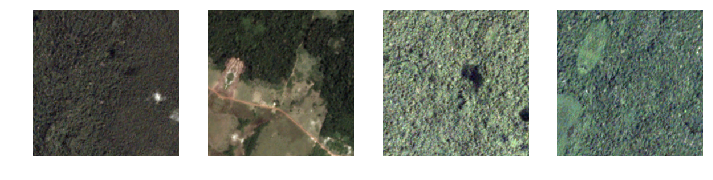

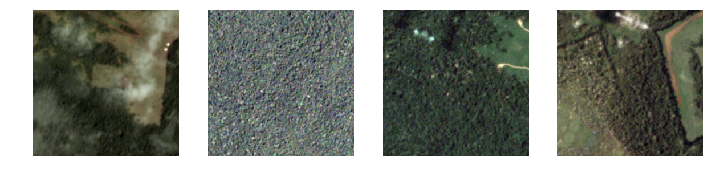

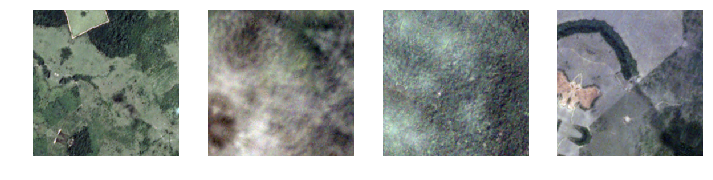

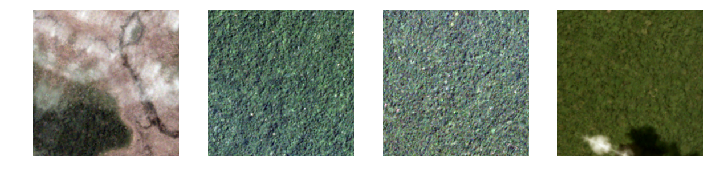

In [34]:
loop_max_counter = 1
for x, y_true, info in val_flow:
        
    y_pred = cnn.predict_on_batch(x)
    n = 4
    for counter in range(params['batch_size']):
        print("\n--", info[counter])
        print('y_true: ', y_true[counter, :])
        print('y_pred: ', y_pred[counter, :])
        print('mae: ', mean_absolute_error(y_true[counter, :], y_pred[counter, :]))  
        print('f2: ', fbeta_score(y_true[counter, :], y_pred[counter, :] > 0.5, beta=2.0))          
        
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)        
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

## Predict tags on test data

In [31]:
from data_utils import test_jpg_ids, test_jpg_files
from test_utils import classification_predict as predict

In [32]:
test_id_type_list = []
for image_id in test_jpg_ids:
    test_id_type_list.append((image_id, "Test_jpg"))

print(len(test_id_type_list))

40669


In [33]:
n_folds = 5
predictions = []
run_counter = 0
n_runs = 2

In [34]:
while run_counter < n_runs:
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)

    # SqueezeNet on 5 folds
    for val_fold_index in range(n_folds):
                
        val_fold_index += 1
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        
        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        weights_files = glob(os.path.join(OUTPUT_PATH, "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)
        
        params['seed'] += run_counter
        df = predict(cnn, test_id_type_list, **params)
        predictions.append(df)
 



 ---- New run :  1 / 2


 ---- Validation fold index:  1 / 5

 2017-07-05 01:42:16.912956 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=0_seed=2017_04_val_loss=9.4452_val_precision=0.2647_val_recall=0.6062.h5 9.4452
-- 0 / 64
-- 16 / 64
-- 32 / 64
-- 48 / 64


 ---- Validation fold index:  2 / 5

 2017-07-05 01:42:25.161256 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=1_seed=2017_03_val_loss=10.2769_val_precision=0.1780_val_recall=0.5460.h5 10.2769
-- 0 / 64
-- 16 / 64
-- 32 / 64
-- 48 / 64


 ---- Validation fold index:  3 / 5

 2017-07-05 01:42:32.715950 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=2_seed=2017_04_val_loss=7.9261_val_precision=0.2197_val

In [35]:
import pandas as pd

def compute_mean(predictions):
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

In [39]:
df = compute_mean(predictions)

# info = 'mean_cv=6_squeezenet'
# now = datetime.now()
# sub_file = 'submission_' + info + '.csv'
# sub_file = os.path.join('results', sub_file)
# df.to_csv(sub_file, index=False)

In [37]:
predictions[0].head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,10009.jpg,0.506258,0.562097,0.975057,0.001368,0.049075,0.002451,0.961137,0.661215,0.000105,0.000004,0.990789,0.010330,0.047737,0.033023,0.900089,0.055774,0.597479
1,10013.jpg,0.112824,0.992581,0.665956,0.022905,0.252470,0.002009,0.758580,0.047629,0.030355,0.000051,0.956831,0.045855,0.181108,0.420796,0.425628,0.548716,0.586713
2,10026.jpg,0.683666,0.770768,0.754240,0.005178,0.920248,0.004585,0.557355,0.951823,0.004545,0.000106,0.952081,0.383490,0.100664,0.102589,0.763708,0.336883,0.314157
3,10051.jpg,0.558847,0.923822,0.997724,0.000904,0.736889,0.000934,0.987514,0.774715,0.053452,0.000031,0.848869,0.003037,0.161278,0.065336,0.836500,0.738170,0.758234
4,10050.jpg,0.001674,0.981961,0.694869,0.227738,0.220498,0.000028,0.957476,0.531832,0.078176,0.000003,0.985369,0.361313,0.019534,0.050918,0.999852,0.002664,0.004680


In [38]:
predictions[1].head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,10009.jpg,0.465652,0.030405,0.269544,0.409754,0.857248,0.025975,0.999920,0.051838,0.066960,0.978959,0.883892,0.873516,0.995550,0.026185,0.462543,0.000612,0.000681
1,10039.jpg,0.093729,0.006439,0.759044,0.983510,0.221559,0.087380,0.889295,0.521726,0.998706,0.915714,0.597018,0.769996,0.985642,0.762664,0.908943,0.003693,0.121895
2,10036.jpg,0.561332,0.621638,0.481471,0.177879,0.391414,0.203498,0.980438,0.157688,0.990710,0.993740,0.612709,0.829291,0.997904,0.583979,0.812165,0.000005,0.095353
3,10026.jpg,0.062532,0.030563,0.024138,0.176282,0.614454,0.046622,0.992656,0.032808,0.879304,0.937467,0.414737,0.823702,0.973572,0.532634,0.751906,0.001167,0.028366
4,10011.jpg,0.099131,0.705599,0.583571,0.962048,0.500123,0.025582,0.957145,0.117518,0.997569,0.984932,0.130966,0.229523,0.986412,0.920123,0.739398,0.005017,0.341393


In [40]:
df.head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,0.jpg,0.547587,0.394494,0.748083,0.417404,0.759704,0.189018,0.661740,0.350495,0.622014,0.384360,0.663181,0.509230,0.511590,0.385018,0.720199,0.288789,0.478163
1,1.jpg,0.418558,0.205205,0.738539,0.296904,0.546367,0.327220,0.582137,0.311244,0.478286,0.582767,0.810059,0.641347,0.475419,0.401459,0.787750,0.096000,0.614872
2,10.jpg,0.519530,0.400793,0.584262,0.434872,0.489117,0.170434,0.582213,0.592595,0.593682,0.410522,0.551644,0.484007,0.575560,0.538420,0.883766,0.204803,0.673564
3,100.jpg,0.289584,0.456127,0.891757,0.353185,0.745096,0.119059,0.717935,0.476995,0.553315,0.433153,0.844619,0.636376,0.686859,0.390396,0.892342,0.350472,0.409009
4,1000.jpg,0.481877,0.281683,0.754391,0.282936,0.650377,0.148259,0.534274,0.453858,0.638972,0.476578,0.444342,0.567461,0.597796,0.410205,0.700519,0.346194,0.288687
